In [91]:
import xarray as xr
import cftime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import logging
import cartopy.crs as ccrs
import metpy  
import calendar
import argparse
import glob
import geopandas
from geodatasets import get_path
import seaborn as sns
import statsmodels.api as sm


In [10]:

output_col_names_cohort = ['lon'
,'lat'
,'variable'
,'cohort_number'
,'stand_age'
,'potential_veg'
,'current_veg'
,'subtype'
,'community_type'
,'silt_clay'  ###check this order
,'lc_state'
,'land_area'
,'cohort_area'
,'year'
,'annual_sum'
,'monthly_maximum'
,'monthly_mean'
,'monthly_minimum'
,'Jan'
,'Feb'
,'Mar'
,'Apr'
,'May'
,'Jun'
,'Jul'
,'Aug'
,'Sep'
,'Oct'
,'Nov'
,'Dec'
,'region']

In [25]:
forest_vegs = [4, 5, 6, 8, 9, 10, 11, 16, 17, 18, 19, 20, 25, 33]
forest_types = ["Boreal Forest", "Forested Boreal Wetlands", "Boreal Woodlands","Mixed Temperate Forests", 
               "Temperate Coniferous Forests", "Temperate Deciduous Forests", "Temperate Forested Wetlands", 
               "Tropical Evergreen Forests", "Tropical Forested Wetlands", "Tropical Deciduous Forests", "Xeromorphic Forests and Woodlands"
               ,"Tropical Forested Floodplains", "Temperate Forested Floodplains", "Temperate Broadleaved Evergreen Forests"]


In [54]:
loops = np.arange(0, 400, 20).astype(str)
loops

array(['0', '20', '40', '60', '80', '100', '120', '140', '160', '180',
       '200', '220', '240', '260', '280', '300', '320', '340', '360',
       '380'], dtype='<U21')

In [32]:
dir_p = '/home/smmrrr/TEM/TEM_Runs/TEM_parallel_run_support_code/amazon_ensemble/' 
period = 'future/'
model = 'AWIxxCMxx1xx1xxMR/'
scenario = 'ssp126/'
var = 'NPP.csv'
group = '0'

In [ ]:
data = pd.read_csv(dir_p + period + scenatio+ model +'var_out/'+ var+group
           ,names = output_col_names_cohort)


In [60]:
all_data = pd.DataFrame(columns = ['lon', 'lat', 'year', 'current_veg', 'stand_age_interval_min', 'temp_weight',
       'cohort_area', 'annual_sum', 'model', 'scenario'])
intervals_standage = [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 3000]


In [61]:
all_data

,lon,lat,year,current_veg,stand_age_interval_min,temp_weight,cohort_area,annual_sum,model,scenario


In [62]:
for model in ('AWIxxCMxx1xx1xxMR'
,'BCCxxCSM2xxMR'
,'MIROC6'
,'MPIxxESM1xx2xxHR'
,'MPIxxESM1xx2xxLR'
,'MRIxxESM2xx0'):
    for scenario in ('ssp126', 'ssp245', 'ssp585'):

        for group in loops:
            
            data = pd.read_csv(dir_p + period + scenario +'/'+ model+'/' +'var_out/'+ var+group
                       ,names = output_col_names_cohort)


            if len(data)>0:
                data = data.loc[data['current_veg'].isin(forest_vegs)]
                data['temp_weight'] = data['annual_sum'] * data['cohort_area'] 

                data['stand_age_bin'] = pd.cut(
                data['stand_age'], bins=intervals_standage)
                data['stand_age_interval_min'] = data['stand_age_bin'].apply(lambda x: x.left).astype(int) + 1


                data_sum = data.groupby(
                    ['lon','lat','year','current_veg', 'stand_age_interval_min']
                )[['temp_weight', 'cohort_area']].sum()

                # all_grids =  all_grids.reset_index()

                data_sum['annual_sum'] = data_sum['temp_weight']/data_sum['cohort_area']
                data_sum = data_sum.reset_index()
                data_sum['model'] = model
                data_sum['scenario'] = scenario

                all_data =  pd.concat([all_data, data_sum], axis = 0)

        print(scenario)
    print(model)
    
    
all_data['temp_weight'] = all_data['annual_sum'] * all_data['cohort_area'] 


all_data = all_data.groupby(
    ['lon','lat','year','current_veg', 'stand_age_interval_min', 'model', 'scenario']
)[['temp_weight', 'cohort_area']].sum()

# all_grids =  all_grids.reset_index()

all_data['annual_sum'] = all_data['temp_weight']/all_data['cohort_area']
all_data = all_data.reset_index()
all_data.to_csv('VEGC_analysis.csv', index = False)        



ssp126
ssp245
ssp585
AWIxxCMxx1xx1xxMR
ssp126
ssp245
ssp585
BCCxxCSM2xxMR
ssp126
ssp245
ssp585
MIROC6
ssp126
ssp245
ssp585
MPIxxESM1xx2xxHR
ssp126
ssp245
ssp585
MPIxxESM1xx2xxLR
ssp126
ssp245
ssp585
MRIxxESM2xx0


In [70]:
all_data['annual_sum'] = all_data['annual_sum']/12

In [71]:
all_data['change_variable'] = all_data['annual_sum'] - all_data.groupby(['lon', 'lat', 'current_veg', 'stand_age_interval_min', 'model', 'scenario'])['annual_sum'].shift(1)
all_data['yr_check'] = all_data['year'] - all_data.groupby(['lon', 'lat', 'current_veg', 'stand_age_interval_min', 'model', 'scenario'])['year'].shift(1)


In [64]:
all_data.describe() 


,lon,lat,year,current_veg,stand_age_interval_min,temp_weight,cohort_area,annual_sum,change_variable,yr_check
count,2.277210e+06,2.277210e+06,2.277210e+06,2.277210e+06,2.277210e+06,2.277210e+06,2.277210e+06,2.271514e+06,2.230486e+06,2.235926e+06
mean,-5.905498e+01,1.912933e-01,2.058319e+03,1.664798e+01,6.655980e+01,1.546551e+08,4.607139e+02,1.887114e+05,3.252057e+02,1.110539e+00
std,2.168307e+00,4.152832e+00,2.482216e+01,2.248484e+00,5.059388e+01,8.484820e+08,1.005204e+03,3.417582e+05,1.948581e+04,2.025658e+00
min,-6.200000e+01,-5.500000e+00,2.015000e+03,1.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.668150e+06,1.000000e+00
25%,-6.100000e+01,-3.500000e+00,2.037000e+03,1.600000e+01,2.100000e+01,8.891495e+04,5.000000e+00,9.077671e+03,-8.505281e+02,1.000000e+00
50%,-5.950000e+01,-5.000000e-01,2.059000e+03,1.600000e+01,6.100000e+01,1.385113e+06,1.600000e+01,1.414272e+05,0.000000e+00,1.000000e+00
75%,-5.700000e+01,4.500000e+00,2.080000e+03,1.600000e+01,1.010000e+02,9.962400e+06,9.600000e+01,2.477681e+05,2.299846e+03,1.000000e+00
max,-5.500000e+01,8.500000e+00,2.100000e+03,3.300000e+01,1.510000e+02,2.374457e+10,3.091000e+03,8.205364e+06,2.360730e+06,8.100000e+01


In [65]:
all_data.loc[all_data['yr_check']>1]

,lon,lat,year,current_veg,stand_age_interval_min,model,scenario,temp_weight,cohort_area,annual_sum,change_variable,yr_check
3588,-62.0,-5.5,2040,16,21,AWIxxCMxx1xx1xxMR,ssp245,154622.8,1,154622.8,-54193.3,19.0
3589,-62.0,-5.5,2040,16,21,AWIxxCMxx1xx1xxMR,ssp585,163491.7,1,163491.7,-39588.5,19.0
3590,-62.0,-5.5,2040,16,21,BCCxxCSM2xxMR,ssp245,65523.7,1,65523.7,-51367.5,19.0
3591,-62.0,-5.5,2040,16,21,BCCxxCSM2xxMR,ssp585,94659.5,1,94659.5,-23941.8,19.0
3592,-62.0,-5.5,2040,16,21,MIROC6,ssp245,259251.1,1,259251.1,114511.1,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2269057,-55.0,5.0,2046,16,101,MPIxxESM1xx2xxHR,ssp585,0.0,1,0.0,0.0,25.0
2269058,-55.0,5.0,2046,16,101,MPIxxESM1xx2xxLR,ssp126,518.9,1,518.9,242.6,25.0
2269059,-55.0,5.0,2046,16,101,MPIxxESM1xx2xxLR,ssp585,372.9,1,372.9,96.6,25.0
2269060,-55.0,5.0,2046,16,101,MRIxxESM2xx0,ssp126,198013.0,1,198013.0,15476.6,25.0


In [66]:
all_data

,lon,lat,year,current_veg,stand_age_interval_min,model,scenario,temp_weight,cohort_area,annual_sum,change_variable,yr_check
0,-62.0,-5.5,2015,16,21,AWIxxCMxx1xx1xxMR,ssp126,195505.4,1,195505.400000,NaN,NaN
1,-62.0,-5.5,2015,16,21,AWIxxCMxx1xx1xxMR,ssp245,195813.4,1,195813.400000,NaN,NaN
2,-62.0,-5.5,2015,16,21,AWIxxCMxx1xx1xxMR,ssp585,196908.9,1,196908.900000,NaN,NaN
3,-62.0,-5.5,2015,16,21,BCCxxCSM2xxMR,ssp126,107080.6,1,107080.600000,NaN,NaN
4,-62.0,-5.5,2015,16,21,BCCxxCSM2xxMR,ssp245,106176.4,1,106176.400000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2277205,-55.0,5.0,2100,16,151,MPIxxESM1xx2xxHR,ssp585,0.0,2917,0.000000,0.000000,1.0
2277206,-55.0,5.0,2100,16,151,MPIxxESM1xx2xxLR,ssp126,179837256.9,2966,60632.925455,-2102.290964,1.0
2277207,-55.0,5.0,2100,16,151,MPIxxESM1xx2xxLR,ssp585,91750854.9,2917,31453.841241,-608.991155,1.0
2277208,-55.0,5.0,2100,16,151,MRIxxESM2xx0,ssp126,644619447.0,2966,217336.293661,185.307957,1.0


In [73]:
all_data.loc[(all_data['annual_sum']<100000) & (all_data['yr_check']==1)]

,lon,lat,year,current_veg,stand_age_interval_min,model,scenario,temp_weight,cohort_area,annual_sum,change_variable,yr_check
144,-62.0,-5.5,2016,16,21,AWIxxCMxx1xx1xxMR,ssp126,188099.0,1,15674.916667,-617.200000,1.0
145,-62.0,-5.5,2016,16,21,AWIxxCMxx1xx1xxMR,ssp245,188713.5,1,15726.125000,-591.658333,1.0
146,-62.0,-5.5,2016,16,21,AWIxxCMxx1xx1xxMR,ssp585,190875.6,1,15906.300000,-502.775000,1.0
147,-62.0,-5.5,2016,16,21,BCCxxCSM2xxMR,ssp126,113394.4,1,9449.533333,526.150000,1.0
148,-62.0,-5.5,2016,16,21,BCCxxCSM2xxMR,ssp245,108281.5,1,9023.458333,175.425000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2277205,-55.0,5.0,2100,16,151,MPIxxESM1xx2xxHR,ssp585,0.0,2917,0.000000,0.000000,1.0
2277206,-55.0,5.0,2100,16,151,MPIxxESM1xx2xxLR,ssp126,179837256.9,2966,5052.743788,-175.190914,1.0
2277207,-55.0,5.0,2100,16,151,MPIxxESM1xx2xxLR,ssp585,91750854.9,2917,2621.153437,-50.749263,1.0
2277208,-55.0,5.0,2100,16,151,MRIxxESM2xx0,ssp126,644619447.0,2966,18111.357805,15.442330,1.0


In [79]:
len(all_data.loc[(all_data['change_variable'].between(-5000, 5000)) & (all_data['yr_check']==1)])

2206897

In [80]:
all_data.loc[(all_data['change_variable']==0)]

,lon,lat,year,current_veg,stand_age_interval_min,model,scenario,temp_weight,cohort_area,annual_sum,change_variable,yr_check
153,-62.0,-5.5,2016,16,21,MPIxxESM1xx2xxHR,ssp126,0.0,1,0.0,0.0,1.0
154,-62.0,-5.5,2016,16,21,MPIxxESM1xx2xxHR,ssp245,0.0,1,0.0,0.0,1.0
171,-62.0,-5.5,2016,16,61,MPIxxESM1xx2xxHR,ssp126,0.0,3,0.0,0.0,1.0
172,-62.0,-5.5,2016,16,61,MPIxxESM1xx2xxHR,ssp245,0.0,3,0.0,0.0,1.0
189,-62.0,-5.5,2016,16,71,MPIxxESM1xx2xxHR,ssp126,0.0,7,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2277193,-55.0,5.0,2100,16,126,MPIxxESM1xx2xxHR,ssp585,0.0,7,0.0,0.0,1.0
2277198,-55.0,5.0,2100,16,151,AWIxxCMxx1xx1xxMR,ssp126,0.0,2966,0.0,0.0,1.0
2277199,-55.0,5.0,2100,16,151,AWIxxCMxx1xx1xxMR,ssp585,0.0,2917,0.0,0.0,1.0
2277204,-55.0,5.0,2100,16,151,MPIxxESM1xx2xxHR,ssp126,0.0,2966,0.0,0.0,1.0


In [81]:
305227/2206897

0.13830595628160264

<Axes: xlabel='annual_sum', ylabel='Count'>

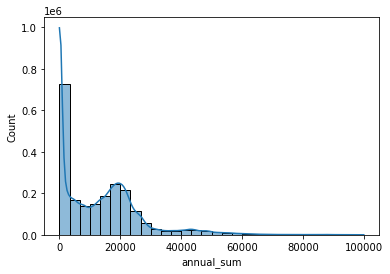

In [74]:
sns.histplot(data=all_data.loc[(all_data['annual_sum']<100000) & (all_data['yr_check']==1)]
             , x='annual_sum'#, hue = 'subtype'
             , bins=30, kde=True) 

<Axes: xlabel='change_variable', ylabel='Count'>

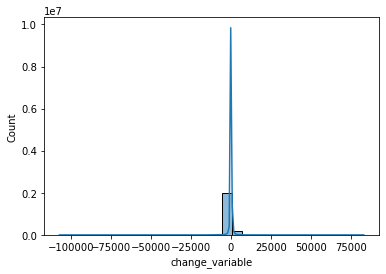

In [75]:
sns.histplot(data=all_data.loc[(all_data['annual_sum']<100000) & (all_data['yr_check']==1)]
             , x='change_variable'#, hue = 'subtype'
             , bins=30, kde=True) 

<Axes: xlabel='change_variable', ylabel='Count'>

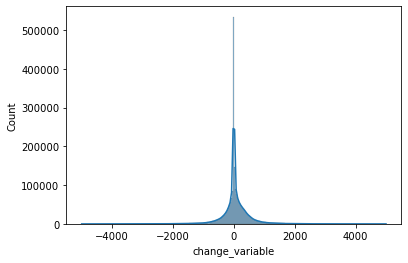

In [78]:
sns.histplot(data=all_data.loc[(all_data['change_variable'].between(-5000, 5000)) & (all_data['yr_check']==1)]
             , x='change_variable'#, hue = 'subtype'
             , bins=300, kde=True) 

<Axes: xlabel='change_variable', ylabel='Count'>

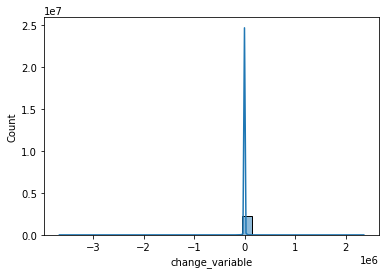

In [68]:
sns.histplot(data=all_data.loc[(all_data['annual_sum']<100000) & (all_data['yr_check']==1)]
             , x='change_variable'#, hue = 'subtype'
             , bins=30, kde=True) 

In [82]:
equil_data = pd.DataFrame(columns = ['lon', 'lat', 'year', 'current_veg',  'temp_weight',
       'cohort_area', 'annual_sum', 'model'])

In [99]:
data = pd.read_csv(dir_p + period + scenario +'/'+ model+'/' +'var_out/'+ var+group
                   ,names = output_col_names_cohort)


In [105]:
data.loc[(data['current_veg'].isin(forest_vegs)) & (data['year']==1501)]

,lon,lat,variable,cohort_number,stand_age,potential_veg,current_veg,subtype,community_type,silt_clay,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,region
0,-59.0,-1.5,VEGC,1,3000,16,16,16,10,62.90,...,19635.58,19670.56,19701.76,19720.53,19663.39,19568.82,19445.42,19358.75,19352.86,Brazil
1,-59.0,-1.5,VEGC,2,426,16,16,16,10,62.90,...,19635.58,19670.56,19701.76,19720.53,19663.39,19568.82,19445.42,19358.75,19352.86,Brazil
986,-59.0,-1.0,VEGC,1,3000,16,16,16,10,62.73,...,19289.26,19325.44,19360.85,19388.68,19368.08,19287.02,19162.74,19054.41,19008.12,Brazil
987,-59.0,-1.0,VEGC,2,426,16,16,16,10,62.73,...,19289.26,19325.44,19360.85,19388.68,19368.08,19287.02,19162.74,19054.41,19008.12,Brazil
1686,-59.0,-0.5,VEGC,1,3000,16,16,16,10,62.54,...,19272.59,19309.05,19344.63,19373.09,19352.73,19271.78,19147.66,19039.34,18992.68,Brazil
1687,-59.0,-0.5,VEGC,2,426,16,16,16,10,62.54,...,19272.59,19309.05,19344.63,19373.09,19352.73,19271.78,19147.66,19039.34,18992.68,Brazil
2386,-59.0,0.0,VEGC,1,3000,16,16,16,10,62.54,...,11787.96,11804.57,11835.14,11871.44,11900.20,11872.61,11797.45,11724.95,11678.83,Brazil
2387,-59.0,0.0,VEGC,2,426,16,16,16,10,62.54,...,11787.96,11804.57,11835.14,11871.44,11900.20,11872.61,11797.45,11724.95,11678.83,Brazil
3679,-59.0,0.5,VEGC,1,3000,16,16,16,10,62.54,...,11783.13,11799.75,11830.43,11866.92,11895.79,11868.19,11792.96,11720.37,11674.08,Brazil
3680,-59.0,0.5,VEGC,2,426,16,16,16,10,62.54,...,11783.13,11799.75,11830.43,11866.92,11895.79,11868.19,11792.96,11720.37,11674.08,Brazil


In [106]:
period = 'pre_data'
scenario = ''
for model in ('AWIxxCMxx1xx1xxMR'
,'BCCxxCSM2xxMR'
,'MIROC6'
,'MPIxxESM1xx2xxHR'
,'MPIxxESM1xx2xxLR'
,'MRIxxESM2xx0'):
    for group in loops:
        data = pd.read_csv(dir_p + period + scenario +'/'+ model+'/' +'var_out/'+ var+group
                   ,names = output_col_names_cohort)

        # print(len(data))
        if len(data)>0:
            data = data.loc[(data['current_veg'].isin(forest_vegs)) & (data['year']==1501)]
            data['temp_weight'] = data['annual_sum'] * data['cohort_area'] 

            data_sum = data.groupby(
                ['lon','lat','year','current_veg']
            )[['temp_weight', 'cohort_area']].sum()

            # all_grids =  all_grids.reset_index()

            data_sum['annual_sum'] = data_sum['temp_weight']/data_sum['cohort_area']
            data_sum = data_sum.reset_index()
            data_sum['model'] = model
            data_sum['scenario'] = scenario

            equil_data =  pd.concat([equil_data, data_sum], axis = 0)

    print(model)
    
    
equil_data.to_csv('VEGC_post_equil_analysis.csv', index = False)        



85092
143517
100485
110228
99988
92992
368160
100008
224976
131163
69736
327269
166052
155521
41255
35992
42259
36612
43565
6440
AWIxxCMxx1xx1xxMR
85050
57826
100591
110167
99995
92955
12701
100016
225209
131449
69736
328139
166583
155939
41165
35973
42243
36612
43567
6443
BCCxxCSM2xxMR
85092
143542
100552
110254
100035
93007
368356
100035
225209
131452
69726
328139
166576
155962
41315
35994
42259
36612
43567
6443
MIROC6
85092
143606
100556
110240
100018
92980
367892
100008
224976
131163
69736
327599
166052
155521
41255
35994
42259
36612
43565
6440
MPIxxESM1xx2xxHR
85092
143518
100588
110180
99996
92947
366788
99777
224469
131077
69728
326979
165951
155476
41315
35994
42259
36612
43567
6443
MPIxxESM1xx2xxLR
85092
143793
100651
110254
100035
93007
368356
100035
225209
131452
69736
328139
166585
155962
41315
35994
42259
36612
43567
6443
MRIxxESM2xx0


In [98]:
data

,lon,lat,variable,cohort_number,stand_age,potential_veg,current_veg,subtype,community_type,silt_clay,...,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,region,temp_weight


In [96]:
dir_p + period + scenario +'/'+ model+'/' +'var_out/'+ var+group

'/home/smmrrr/TEM/TEM_Runs/TEM_parallel_run_support_code/amazon_ensemble/pre_data//MRIxxESM2xx0/var_out/VEGC.csv380'

In [109]:
equil_data

,lon,lat,year,current_veg,temp_weight,cohort_area,annual_sum,model,scenario,initial_stock
0,-62.0,-5.5,1501,16,667688384.1,3077,216993.300000,AWIxxCMxx1xx1xxMR,,18082.775000
1,-62.0,-5.0,1501,16,667876358.6,3079,216913.400000,AWIxxCMxx1xx1xxMR,,18076.116667
2,-62.0,-4.5,1501,20,770169743.4,3081,249973.951120,AWIxxCMxx1xx1xxMR,,20831.162593
3,-62.0,-4.0,1501,20,772528272.6,3083,250576.799416,AWIxxCMxx1xx1xxMR,,20881.399951
4,-62.0,-3.5,1501,16,689136555.0,3085,223383.000000,AWIxxCMxx1xx1xxMR,,18615.250000
...,...,...,...,...,...,...,...,...,...,...
0,-55.0,2.0,1501,16,639669000.6,3087,207213.800000,MRIxxESM2xx0,,17267.816667
1,-55.0,3.5,1501,16,642092402.1,3083,208268.700000,MRIxxESM2xx0,,17355.725000
2,-55.0,4.0,1501,16,646887376.2,3081,209960.200000,MRIxxESM2xx0,,17496.683333
3,-55.0,4.5,1501,16,621913386.9,3079,201985.510523,MRIxxESM2xx0,,16832.125877


In [87]:
len(all_data.loc[(all_data['change_variable'].between(-5000, 5000)) & (all_data['yr_check']==1)])

2206897

In [108]:
equil_data['initial_stock'] = equil_data['annual_sum']/12

In [118]:
model_data = all_data.loc[(all_data['change_variable'].between(-5000, 5000)) & (all_data['yr_check']==1)].merge(equil_data[['lat', 'lon', 'current_veg', 'model','initial_stock']]
,on = ['lat', 'lon', 'current_veg', 'model']
,how = 'inner')

In [119]:
model_data

,lon,lat,year,current_veg,stand_age_interval_min,model,scenario,temp_weight,cohort_area,annual_sum,change_variable,yr_check,initial_stock
0,-62.0,-5.5,2016,16,21,AWIxxCMxx1xx1xxMR,ssp126,1.880990e+05,1,15674.916667,-617.200000,1.0,18082.775
1,-62.0,-5.5,2016,16,21,AWIxxCMxx1xx1xxMR,ssp245,1.887135e+05,1,15726.125000,-591.658333,1.0,18082.775
2,-62.0,-5.5,2016,16,21,AWIxxCMxx1xx1xxMR,ssp585,1.908756e+05,1,15906.300000,-502.775000,1.0,18082.775
3,-62.0,-5.5,2016,16,61,AWIxxCMxx1xx1xxMR,ssp126,6.062221e+05,3,16839.502778,-185.097222,1.0,18082.775
4,-62.0,-5.5,2016,16,61,AWIxxCMxx1xx1xxMR,ssp245,6.113723e+05,3,16982.563889,-69.438194,1.0,18082.775
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173856,-55.0,5.0,2100,16,101,MIROC6,ssp585,4.845613e+06,6,67300.175000,338.041667,1.0,1085.925
2173857,-55.0,5.0,2100,16,126,MIROC6,ssp126,4.296509e+06,7,51148.916667,311.989286,1.0,1085.925
2173858,-55.0,5.0,2100,16,126,MIROC6,ssp585,4.711638e+06,7,56090.934524,341.278571,1.0,1085.925
2173859,-55.0,5.0,2100,16,151,MIROC6,ssp126,2.158174e+09,2966,60636.496460,308.591664,1.0,1085.925


In [113]:
model_data.describe()

,lon,lat,year,stand_age_interval_min,temp_weight,cohort_area,annual_sum,change_variable,yr_check,initial_stock
count,2.206897e+06,2.206897e+06,2.206897e+06,2.206897e+06,2.206897e+06,2.206897e+06,2.206897e+06,2.206897e+06,2206897.0,2.173861e+06
mean,-5.904978e+01,2.120781e-01,2.058872e+03,6.668264e+01,1.576492e+08,4.695628e+02,1.562693e+04,4.838016e+01,1.0,1.473336e+04
std,2.169927e+00,4.157703e+00,2.449766e+01,5.082281e+01,8.560214e+08,1.012101e+03,2.841542e+04,5.417157e+02,0.0,1.005155e+04
min,-6.200000e+01,-5.500000e+00,2.016000e+03,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-4.999419e+03,1.0,0.000000e+00
25%,-6.100000e+01,-3.500000e+00,2.038000e+03,2.100000e+01,9.699900e+04,5.000000e+00,7.606625e+02,-6.787222e+01,1.0,2.965617e+03
50%,-5.950000e+01,-5.000000e-01,2.059000e+03,6.100000e+01,1.474231e+06,1.700000e+01,1.173793e+04,0.000000e+00,1.0,1.690369e+04
75%,-5.700000e+01,4.500000e+00,2.080000e+03,1.010000e+02,1.055436e+07,1.000000e+02,2.061465e+04,1.902083e+02,1.0,2.247362e+04
max,-5.500000e+01,8.500000e+00,2.100000e+03,1.510000e+02,2.374457e+10,3.091000e+03,6.837803e+05,4.999642e+03,1.0,3.348752e+04


In [117]:
model_data.loc[model_data['initial_stock'].isna()]

,lon,lat,year,current_veg,stand_age_interval_min,model,scenario,temp_weight,cohort_area,annual_sum,change_variable,yr_check,initial_stock
203534,-62.0,8.0,2016,19,0,BCCxxCSM2xxMR,ssp126,0.0,20,0.000000,0.000000,1.0,NaN
203535,-62.0,8.0,2016,19,0,BCCxxCSM2xxMR,ssp245,0.0,21,0.000000,0.000000,1.0,NaN
203536,-62.0,8.0,2016,19,0,BCCxxCSM2xxMR,ssp585,0.0,20,0.000000,0.000000,1.0,NaN
203552,-62.0,8.0,2016,19,11,BCCxxCSM2xxMR,ssp126,0.0,22,0.000000,0.000000,1.0,NaN
203553,-62.0,8.0,2016,19,11,BCCxxCSM2xxMR,ssp245,0.0,22,0.000000,0.000000,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
919894,-60.0,6.0,2100,16,81,BCCxxCSM2xxMR,ssp126,2989875.8,16,15572.269792,281.723125,1.0,NaN
919903,-60.0,6.0,2100,16,91,BCCxxCSM2xxMR,ssp126,2287036.6,14,13613.313095,-3780.374405,1.0,NaN
919913,-60.0,6.0,2100,16,101,BCCxxCSM2xxMR,ssp126,7430691.7,25,24768.972333,2130.641333,1.0,NaN
919922,-60.0,6.0,2100,16,126,BCCxxCSM2xxMR,ssp126,3059000.9,9,28324.082407,-1348.423843,1.0,NaN


In [124]:
# Convert the 'Category' column into dummy variables
dummies = pd.get_dummies(model_data['stand_age_interval_min'], prefix='stand_age')

# Join the dummy variables to the original dataframe
model_data = pd.concat([model_data, dummies], axis=1)
model_data.columns

Index(['lon', 'lat', 'year', 'current_veg', 'stand_age_interval_min', 'model',
       'scenario', 'temp_weight', 'cohort_area', 'annual_sum',
       'change_variable', 'yr_check', 'initial_stock', 'stand_age_0',
       'stand_age_11', 'stand_age_21', 'stand_age_31', 'stand_age_41',
       'stand_age_51', 'stand_age_61', 'stand_age_71', 'stand_age_81',
       'stand_age_91', 'stand_age_101', 'stand_age_126', 'stand_age_151',
       'stand_age_0', 'stand_age_11', 'stand_age_21', 'stand_age_31',
       'stand_age_41', 'stand_age_51', 'stand_age_61', 'stand_age_71',
       'stand_age_81', 'stand_age_91', 'stand_age_101', 'stand_age_126',
       'stand_age_151'],
      dtype='object')

In [125]:
model = sm.OLS(model_data['change_variable'], model_data[['initial_stock', 'stand_age_0',
       'stand_age_11', 'stand_age_21', 'stand_age_31', 'stand_age_41',
       'stand_age_51', 'stand_age_61', 'stand_age_71', 'stand_age_81',
       'stand_age_91', 'stand_age_101', 'stand_age_126', 'stand_age_151',
       'stand_age_0', 'stand_age_11', 'stand_age_21', 'stand_age_31',
       'stand_age_41', 'stand_age_51', 'stand_age_61', 'stand_age_71',
       'stand_age_81', 'stand_age_91', 'stand_age_101', 'stand_age_126' ]])

results = model.fit()

##Print the regression results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:        change_variable   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1283.
Date:                Mon, 22 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:49:35   Log-Likelihood:            -1.6773e+07
No. Observations:             2173861   AIC:                         3.355e+07
Df Residuals:                 2173847   BIC:                         3.355e+07
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
initial_stock     0.0045   3.67e-05    123.459

In [121]:
model = sm.OLS(model_data['change_variable'], model_data[['initial_stock' ]])

results = model.fit()

##Print the regression results
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:        change_variable   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                          3.229e+04
Date:                Mon, 22 Jan 2024   Prob (F-statistic):                        0.00
Time:                        19:45:46   Log-Likelihood:                     -1.6774e+07
No. Observations:             2173861   AIC:                                  3.355e+07
Df Residuals:                 2173860   BIC:                                  3.355e+07
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [126]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Assume you have a pandas DataFrame 'df' with feature columns and an 'outcome' column which is the target
# df = pd.read_csv('your_data.csv')  # If you're reading from a CSV file

X = model_data[['initial_stock', 'stand_age_0',
       'stand_age_11', 'stand_age_21', 'stand_age_31', 'stand_age_41',
       'stand_age_51', 'stand_age_61', 'stand_age_71', 'stand_age_81',
       'stand_age_91', 'stand_age_101', 'stand_age_126', 'stand_age_151',
       'stand_age_0', 'stand_age_11', 'stand_age_21', 'stand_age_31',
       'stand_age_41', 'stand_age_51', 'stand_age_61', 'stand_age_71',
       'stand_age_81', 'stand_age_91', 'stand_age_101', 'stand_age_126','stand_age_151' ]]
y = model_data['change_variable']  # Target (outcome column)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
random_forest.fit(X_train, y_train)

# Make predictions
predictions = random_forest.predict(X_test)


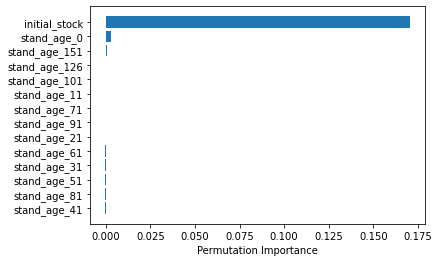

In [129]:
# Perform permutation importance
from sklearn.inspection import permutation_importance
result = permutation_importance(random_forest, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

# Plot the permutation importance
plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()



In [130]:
result.importances_mean[sorted_idx]

array([-3.99710125e-04, -3.96138921e-04, -3.91893112e-04, -3.78016391e-04,
       -2.65518625e-04, -2.64760677e-04, -2.40417799e-04, -2.39942608e-04,
       -2.38895666e-04, -2.35660584e-04, -2.33780810e-04, -2.30091479e-04,
       -2.24125384e-04, -2.23001562e-04, -2.20539481e-04, -2.10113902e-04,
       -2.09155030e-04, -2.08967223e-04, -2.07903685e-04, -2.05006484e-04,
       -1.98325667e-04, -1.93761290e-04, -1.93574659e-04, -1.67445394e-04,
       -1.39173424e-04, -1.07469577e-04, -9.68471803e-05, -9.02447033e-05,
       -8.79596342e-05, -8.71915485e-05, -8.56280352e-05, -8.36624375e-05,
       -6.53690882e-05, -5.88310413e-05, -3.55165316e-05, -3.01426789e-05,
       -2.72857662e-05, -1.64625450e-05, -1.35851957e-05, -7.37591898e-06,
       -4.82343166e-06,  1.47363243e-06,  9.05104568e-06,  1.82739543e-05,
        2.28044876e-04,  2.58273713e-04,  3.29871081e-04,  3.63070238e-04,
        1.10679670e-03,  1.90040553e-03,  1.95645200e-03,  2.97370766e-03,
        1.70265102e-01])

In [127]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Calculate metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R^2): {r2:.2f}')

Mean Absolute Error (MAE): 274.58
Mean Squared Error (MSE): 280556.94
Root Mean Squared Error (RMSE): 529.68
R-squared (R^2): 0.06


In [35]:
all_data['temp_weight'] = all_data['annual_sum'] * all_data['cohort_area'] 


all_data = all_data.groupby(
    ['lon','lat','year','current_veg', 'stand_age']
)[['temp_weight', 'cohort_area']].sum()

# all_grids =  all_grids.reset_index()

all_data['annual_sum'] = all_data['temp_weight']/all_data['cohort_area']
all_data = all_data.reset_index()
all_data.to_csv('vegc_analysis.csv')

,lon,lat,year,current_veg,stand_age,temp_weight,cohort_area,annual_sum,model,scenario
0,-62.0,-5.5,2015,16,24,195505.4,1,195505.4,AWIxxCMxx1xx1xxMR/,ssp126/
1,-62.0,-5.5,2015,16,67,203269.8,1,203269.8,AWIxxCMxx1xx1xxMR/,ssp126/
2,-62.0,-5.5,2015,16,68,204011.7,1,204011.7,AWIxxCMxx1xx1xxMR/,ssp126/
3,-62.0,-5.5,2015,16,69,204531.1,1,204531.1,AWIxxCMxx1xx1xxMR/,ssp126/
4,-62.0,-5.5,2015,16,70,205368.2,1,205368.2,AWIxxCMxx1xx1xxMR/,ssp126/
...,...,...,...,...,...,...,...,...,...,...
26385,-62.0,-3.5,2098,16,545,288986.5,1,288986.5,AWIxxCMxx1xx1xxMR/,ssp126/
26386,-62.0,-3.5,2098,16,551,288986.3,1,288986.3,AWIxxCMxx1xx1xxMR/,ssp126/
26387,-62.0,-3.5,2098,16,557,288986.3,1,288986.3,AWIxxCMxx1xx1xxMR/,ssp126/
26388,-62.0,-3.5,2098,16,562,288986.3,1,288986.3,AWIxxCMxx1xx1xxMR/,ssp126/


In [36]:
data

,lon,lat,variable,cohort_number,stand_age,potential_veg,current_veg,subtype,community_type,silt_clay,...,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,region,temp_weight
0,-62.0,-5.5,VEGC,1,3000,16,16,16,10,59.82,...,20918.86,20889.70,20841.36,20737.93,20576.58,20410.30,20332.28,20343.57,Brazil,756049135.8
1,-62.0,-5.5,VEGC,2,940,16,16,16,10,59.82,...,20918.86,20889.70,20841.36,20737.93,20576.58,20410.30,20332.28,20343.57,Brazil,1244320.5
2,-62.0,-5.5,VEGC,3,476,16,16,16,10,59.82,...,20896.11,20866.68,20818.20,20714.78,20553.77,20387.84,20310.08,20321.48,Brazil,248595.8
3,-62.0,-5.5,VEGC,4,449,16,16,16,10,59.82,...,20887.03,20857.75,20809.38,20706.07,20544.95,20378.92,20301.10,20312.52,Brazil,248485.8
4,-62.0,-5.5,VEGC,5,402,16,16,16,10,59.82,...,20894.51,20865.37,20817.07,20713.71,20552.44,20386.26,20308.34,20319.49,Brazil,248573.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37315,-62.0,-3.5,VEGC,17,515,16,16,16,10,61.31,...,24191.10,24233.47,24255.47,24234.88,24075.15,23916.34,23920.50,23963.84,Brazil,0.0
37316,-62.0,-3.5,VEGC,18,489,16,16,16,10,61.31,...,24191.20,24233.64,24255.62,24234.99,24075.25,23916.44,23920.60,23963.95,Brazil,288987.7
37317,-62.0,-3.5,VEGC,19,469,16,16,16,10,61.31,...,24190.61,24233.22,24255.13,24234.42,24074.60,23915.72,23919.90,23963.20,Brazil,288980.5
37318,-62.0,-3.5,VEGC,20,219,16,16,16,10,61.31,...,24145.92,24187.97,24209.94,24189.79,24031.29,23873.68,23877.81,23877.82,Brazil,288579.0


In [14]:
### take the weighted average of the non agg version
####get weighted average
data['temp_weight'] = data['annual_sum'] * data['cohort_area'] 


data_sum = data.groupby(
    ['lon','lat','year','subtype']
)[['temp_weight', 'cohort_area']].sum()

# all_grids =  all_grids.reset_index()

data_sum['annual_sum'] = data_sum['temp_weight']/data_sum['cohort_area']
data_sum = data_sum.reset_index()



In [15]:
data_sum

,lon,lat,year,subtype,temp_weight,cohort_area,annual_sum
0,-62.0,-5.5,1501,16,1989895.9,3077,646.7
1,-62.0,-5.5,1502,16,2158515.5,3077,701.5
2,-62.0,-5.5,1503,16,2563448.7,3077,833.1
3,-62.0,-5.5,1504,16,3044383.8,3077,989.4
4,-62.0,-5.5,1505,16,2689298.0,3077,874.0
...,...,...,...,...,...,...,...
10172,-62.0,4.0,1846,16,0.0,3081,0.0
10173,-62.0,4.0,1847,16,0.0,3081,0.0
10174,-62.0,4.0,1848,16,0.0,3081,0.0
10175,-62.0,4.0,1849,16,0.0,3081,0.0


In [ ]:
sns.scatterplot(x='lon'
                , y='lab', hue='group_column', data=df)

<Axes: xlabel='annual_sum', ylabel='Count'>

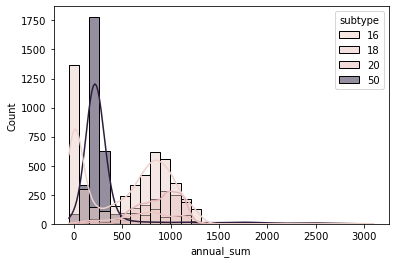

In [19]:
sns.histplot(data=data_sum
             , x='annual_sum', hue = 'subtype'
             , bins=30, kde=True)  # Adjust 'bins' and 'kde' as needed

<Axes: xlabel='annual_sum', ylabel='Count'>

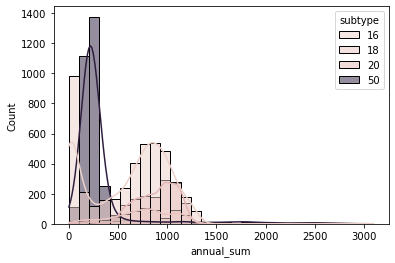

In [20]:
sns.histplot(data=data_sum.loc[data_sum['annual_sum']>0]
             , x='annual_sum', hue = 'subtype'
             , bins=30, kde=True)  # Adjust 'bins' and 'kde' as needed

In [ ]:
sns.histplot(data=data_sum
             , x='annual_sum'
             , bins=30, kde=True)  # Adjust 'bins' and 'kde' as needed

In [17]:
data_sum.subtype.unique()

array([16, 50, 20, 18])

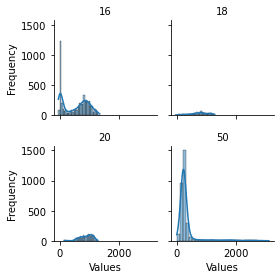

In [18]:
# Create a FacetGrid
g = sns.FacetGrid(data_sum, col='subtype', col_wrap=2, height=2)  # Adjust 'col_wrap' and 'height' as needed

# Map the histogram onto the grid
g.map(sns.histplot, 'annual_sum', bins=30, kde=True)  # Adjust 'bins' and 'kde' as needed

# Set titles and labels
g.set_axis_labels('Values', 'Frequency')
g.set_titles(col_template='{col_name}')

plt.show()